In [ ]:
!pip install qiskit
!pip install pylatexenc

In [3]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
import math

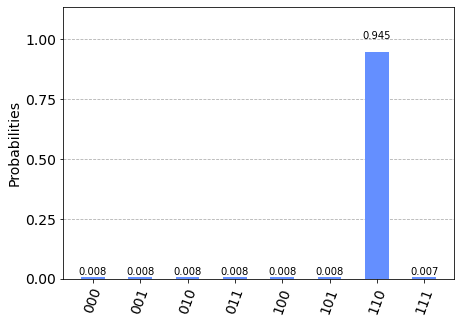

In [36]:
#first we choose a state to search for which is searching for a single value
desired_state="110"
#we can put any state insted of 110 .. it's just a choice
N=len(desired_state)
number_of_iterations=math.floor(3.14*0.25*math.sqrt(2**N))
#it's 3.14*0.25*sqaure root of(2^N) because we are searching for a single vlaue
my_circuit=QuantumCircuit(2*N-2,N)
#the number of Qubits is (2N-2) because we will use CCNOT gate which requires (N-2)additional helping Qubits
my_circuit.h(range(0,N-1))
#we choose the range from 0 to N-1 because in the N-1 position there is a helping Qubit. So we only can apply H on the first N-1 Qubits
my_circuit.h([2*N-3])
#then we apply H on the last Qubit
my_circuit.barrier()
#any barrier is to make the circuit looks nice and organized

#here we define the Quantum Oracle for N Qbit System
for j in range(int(number_of_iterations)):
  #the for loop repeats the circuit in order to get closer to the desired value (the chosen value) 
    for k in range(N-1):
  #this loop should search for the zeros within the desired state
        if desired_state[k]=="0":
            my_circuit.x(k)
          #this step would be applying X gate on the kth state to convert 0 to 1

    if desired_state[N-1]=="0":
        my_circuit.x(2*N-3)
      #this step to check whether the last bit in the desired state is 0, if so, it puts X gate on the last Qbit
       #we manged to prevent applying X gate on the helping Qubit via choisng the correct range
    my_circuit.barrier()
  
#now we should use the CCX gate (toffoli gate) such that if its two control bits are 1 and 1, it permits the CZ gate to be applied
    my_circuit.ccx([0],[1],[N-1])
    #here CCX takes the 1st and the 2nd Qubits (which are q0 and q1) as its control bits and the N-1 Qubit (the 1st helping Qbit) as its target 
    for k in range(2,N-1):
  #the for loop here allows other CCX gates to run such that,
   #for exmaple, the 2nd CCX would take the 3rd qubit and the 2nd helping Qubit as control and the 3rd helping Qubit as its target
  #the 3rd CCX would take the 4th Qubit and 3rd helping Qubit as controls ... and so on
        my_circuit.ccx([k],[N-3+k],[N-2+k])
    #now for each CCX that happens to have its controls 1 and 1, the CZ gate must apply such that it flips the sign of its target if it's 1    
    my_circuit.cz([2*N-4],[2*N-3])
    for k in range(N-2,1,-1):
      #this for loop comes because of the fact that CCX is a unitary operator. So we want to sandwich the CZ gate btween two CCX gates
      #so we must apply the CCX again in the reverse order and this returns any helping Qubit to its original state
        my_circuit.ccx([k],[N-3+k],[N-2+k])
    my_circuit.ccx([0],[1],[N-1])
    my_circuit.barrier()

#also here we must sandwich the CCX, CZ, and CCX gate btween X gates
#so we need to apply X gate in the reverse order obeying the same previous constraints and this returns Qubit in-use to its original state
#except for the desired state that picked a negative sign
    for k in range(N-1):
        if desired_state[k]=="0":
            my_circuit.x(k)
    if desired_state[N-1]=="0":
        my_circuit.x(2*N-3)
    my_circuit.barrier()

#Now we can construct the reflection operator Operator that puts a conditional phase shift on the desired state
#This is because we want the previously flipped sign to be restored and the amplitude to be amplified
#applying Hadamard transformation first to all Qubit except for the helping ones
    my_circuit.h(range(0,N-1))
    my_circuit.h([2*N-3])
 #applying X gates to all Qubits in-use except for the helping ones
 #this is to change all the resulting zaeros into ones and vice versa which returns the desired state up to negative sign.   
    my_circuit.x(range(0,N-1))
    my_circuit.x([2*N-3])
    my_circuit.barrier()
#to resolve the negative sign we need to take the same path of two toffoli gates sandwiching a CZ gate
#this is applied individually per each helping Qubit serving as a control bit to the CZ gate and hence, we need a for loop
    my_circuit.ccx([0],[1],[N-1])
      #the indicies runs such that it captures all the resulting vlaues and CZ only applies for its target if its control is 1
    for k in range(2,N-1):
        my_circuit.ccx([k],[N-3+k],[N-2+k])
    my_circuit.cz([2*N-4],[2*N-3])
  #Now we obey unitarity by reapplying CCX gates in the reverse order
    for k in range(N-2,1,-1):
        my_circuit.ccx([k],[N-3+k],[N-2+k])
    my_circuit.ccx([0],[1],[N-1])
    my_circuit.barrier()
#again guided by the unitarity of the operators, we must reapply X gates in the reverse order
    my_circuit.x(range(0,N-1))
    my_circuit.x([2*N-3])
    my_circuit.h(range(0,N-1))
    my_circuit.h([2*N-3])
    my_circuit.barrier()

#Now we can measure the amplified amplitude of our desired state  
my_circuit.measure(range(N-1),range(N-1,0,-1))
my_circuit.measure([2*N-3],[0])
backend=Aer.get_backend('qasm_simulator')
result=execute(my_circuit,backend=backend,shots=100000).result()
#here 100000 shots mean the circuit will repeat 100000
counts=result.get_counts()
#here counts mean how many times each state has been obtained avaraged by the total number of shots
plot_histogram(counts)
#this histogram shows the amplified amplitude squared of the state 110 after 100000 shots which is the probability of measuring this state

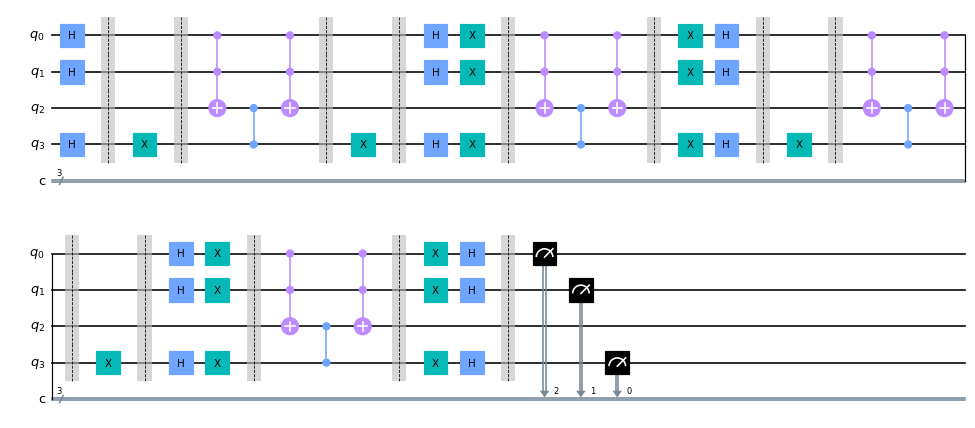

In [37]:
%matplotlib inline
my_circuit.draw(output="mpl",scale=0.8, vertical_compression="low")
#here is the plot of the circuit for the state 110
#if you changed the state in the beginning of the code you should change the bove line accordingly